In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

np.random.seed(42)

In [2]:
import pymc3 as pm
import scipy.stats as stats
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.6


Initial propulation and probability of 'removal'

In [3]:
N_0 = 100
actual_prob = 0.8  # Friend is good at finding the legos

## Single Pass Done One Thousand Times

In [11]:
X_1 = np.random.binomial(N_0, actual_prob, size=1000)  
# Number removed, to do, change to X_1

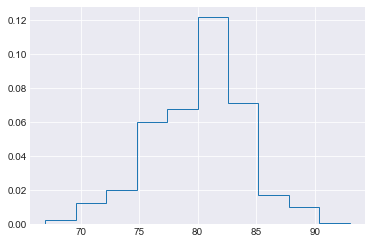

In [12]:
plt.hist(X_1, histtype='step', density=True);
x = np.linspace(0, 100, 100)

In [13]:
alpha=2  # or 1.1
beta=2   # or 1.1

basic_model = pm.Model()

with basic_model:
    p = pm.Beta('p', alpha=alpha, beta=beta)
    n_0 = pm.DiscreteUniform('n_0', lower=np.min(N_1), upper=200)
        # TODO What is size of bucket of legos?
    x_1 = pm.Binomial('x_1', n=n_0, p=p, observed=X_1)

In [20]:
with basic_model:
    step = pm.Slice()
    trace = pm.sample(50000, step, random_seed=123, progressbar=True) 
    # TODO increase tuning

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [n_0]
>Slice: [p]
Sampling 2 chains: 100%|██████████| 101000/101000 [02:19<00:00, 726.57draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


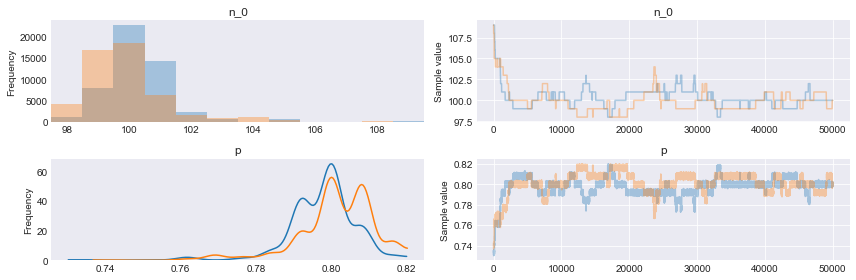

In [21]:
pm.traceplot(trace, varnames=['n_0', 'p']);  # Poor KDE smoothing on p

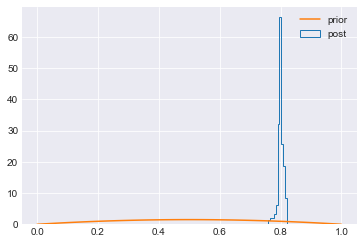

In [22]:
plt.hist(trace['p'], 15, histtype='step', density=True, label='post');
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, alpha, beta), label='prior');
plt.legend(loc='best');

In [23]:
with basic_model:
    trace = pm.sample(50000, random_seed=123, progressbar=True)
    # Todo increase tuning steps

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [p]
>Metropolis: [n_0]
Sampling 2 chains: 100%|██████████| 101000/101000 [01:47<00:00, 943.03draws/s]
The acceptance probability does not match the target. It is 0.8956947562814067, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8982297282562441, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


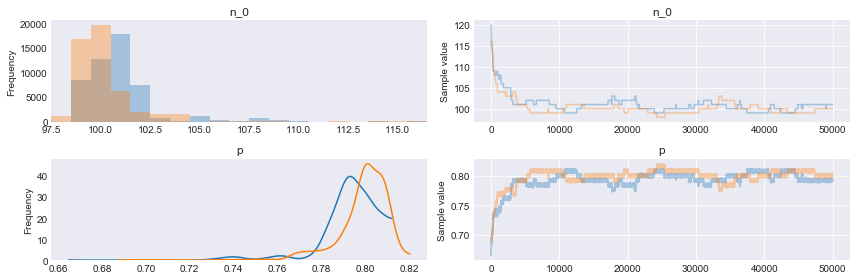

In [24]:
pm.traceplot(trace, varnames=['n_0', 'p']);

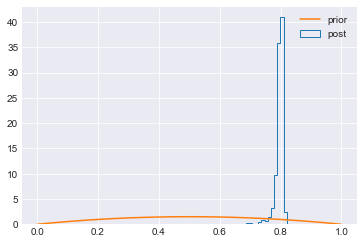

In [25]:
plt.hist(trace['p'], 15, histtype='step', density=True, label='post');
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, alpha, beta), label='prior');
plt.legend(loc='best');

## Single Pass Done Once

In [26]:
np.random.seed(42)
X_1 = np.random.binomial(N_0, actual_prob)
X_1

81

In [41]:
basic_model = pm.Model()

with basic_model:
    p = pm.Beta('p', alpha=alpha, beta=beta)
    n_0 = pm.DiscreteUniform('n_0', lower=X_1, upper=3000)  # Lots of legos
    x_1 = pm.Binomial('x_1', n=n_0, p=p, observed=X_1)

In [42]:
with basic_model:
    step = pm.Slice()
    trace = pm.sample(50000, step, tuning=5000, random_seed=123, progressbar=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [n_0]
>Slice: [p]
Sampling 2 chains: 100%|██████████| 101000/101000 [01:26<00:00, 1173.01draws/s]
The number of effective samples is smaller than 10% for some parameters.


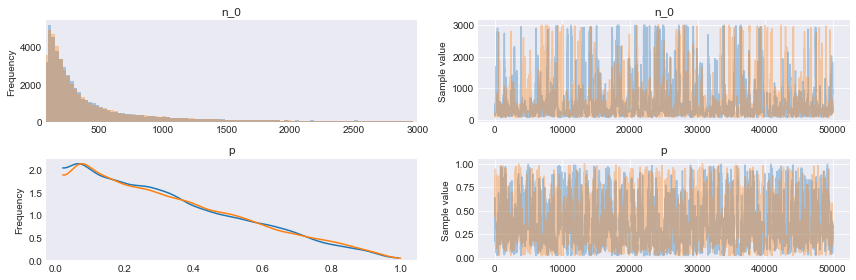

In [43]:
pm.traceplot(trace, varnames=['n_0', 'p']);

In [44]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
n_0,478.67,515.45,18.88,81.00,1650.00,717.91,1.0
p,0.34,0.23,0.01,0.02,0.78,667.28,1.0


## Two Passes - One Time

In [30]:
np.random.seed(42)
X_1 = np.random.binomial(N_0, actual_prob)  # First Removal
N_1 = N_0 - X_1   # Number remaining after first removal
X_2 = np.random.binomial(N_1, actual_prob)  # Second Removal
print('First removal = {}, Second removal = {}'.format(X_1, X_2))

First removal = 81, Second removal = 12


In [31]:
basic_model = pm.Model()

with basic_model:
    p = pm.Beta('p', alpha=alpha, beta=beta)
    n_0 = pm.DiscreteUniform('n_0', lower=X_1+X_2, upper=3000)
    x_1 = pm.Binomial('x_1', n=n_0, p=p, observed=X_1)
    n_1 = n_0 - x_1
    x_2 = pm.Binomial('x_2', n=n_1, p=p, observed=X_2)

In [32]:
with basic_model:
    step = pm.Slice()
    trace = pm.sample(50000, step, tuning=5000, random_seed=123, progressbar=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [n_0]
>Slice: [p]
Sampling 2 chains: 100%|██████████| 101000/101000 [01:32<00:00, 1090.30draws/s]
The number of effective samples is smaller than 25% for some parameters.


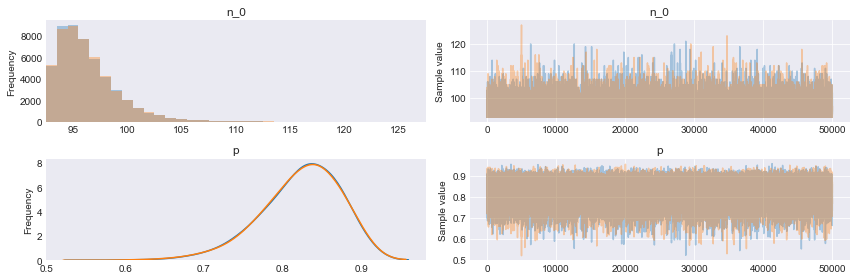

In [33]:
pm.traceplot(trace, varnames=['n_0', 'p']);

In [34]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
n_0,96.36,2.85,0.02,93.00,102.00,24846.48,1.0
p,0.82,0.05,0.00,0.72,0.92,27436.66,1.0


## Three passes

In [45]:
np.random.seed(42)
X_1 = np.random.binomial(N_0, actual_prob)  # First Removal
N_1 = N_0 - X_1
X_2 = np.random.binomial(N_1, actual_prob)  # Second Removal
N_2 = N_1 - X_2
X_3 = np.random.binomial(N_2, actual_prob) # Third Removal
print('First removal = {}, Second removal = {}, Third removal = {}'.format(X_1, X_2, X_3))

First removal = 81, Second removal = 12, Third removal = 5


In [50]:
basic_model = pm.Model()

with basic_model:
    p = pm.Beta('p', alpha=alpha, beta=beta)
    n_0 = pm.DiscreteUniform('n_0', lower=0, upper=3000) # Loosen prior, was X_1+X_2+X_3
    x_1 = pm.Binomial('x_1', n=n_0, p=p, observed=X_1)
    n_1 = n_0 - x_1
    x_2 = pm.Binomial('x_2', n=n_1, p=p, observed=X_2)
    n_2 = n_1 - x_2
    x_3 = pm.Binomial('x_3', n=n_2, p=p, observed=X_3)

In [51]:
with basic_model:
    step = pm.Slice()
    trace = pm.sample(50000, step, tuning=5000, random_seed=123, progressbar=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [n_0]
>Slice: [p]
Sampling 2 chains: 100%|██████████| 101000/101000 [01:46<00:00, 947.93draws/s]


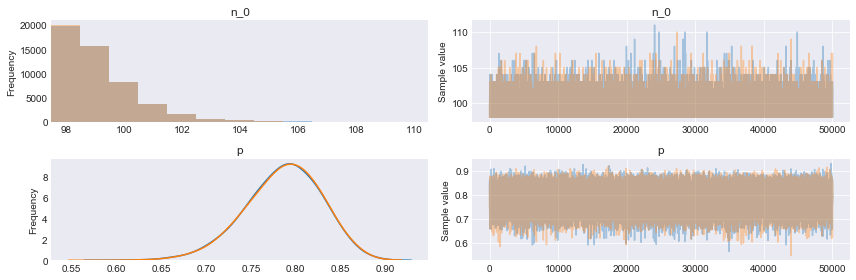

In [52]:
pm.traceplot(trace, varnames=['n_0', 'p']);

In [53]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
n_0,99.10,1.26,0.01,98.0,102.00,36617.36,1.0
p,0.79,0.04,0.00,0.7,0.87,47759.27,1.0
